In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from src.onnx_model import YoloOnnxModel
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch import nn
import cv2
import torch
from ultralytics import YOLO
import onnxruntime as ort
import torchvision
from src.utils.vision import non_maximum_supression
from src.visualization import plot_yolo_labels
from src.transforms import xywh2xyxy, xywhn2xywh

CONF_THRESHOLD = 0.25
IOU_THRESHOLD = 0.

onnx_model = YoloOnnxModel("../models/detection_model.onnx")

In [40]:
image = Image.open("../datasets/yolo_HWD+/images/test/42.png")
img = np.asarray(image)[..., :3]
img = img[100:-50, 40:-50]
input_image = np.copy(img)
input_tensor, pad = onnx_model.prepare_input(input_image)
outputs = onnx_model.inference(input_tensor)[0]

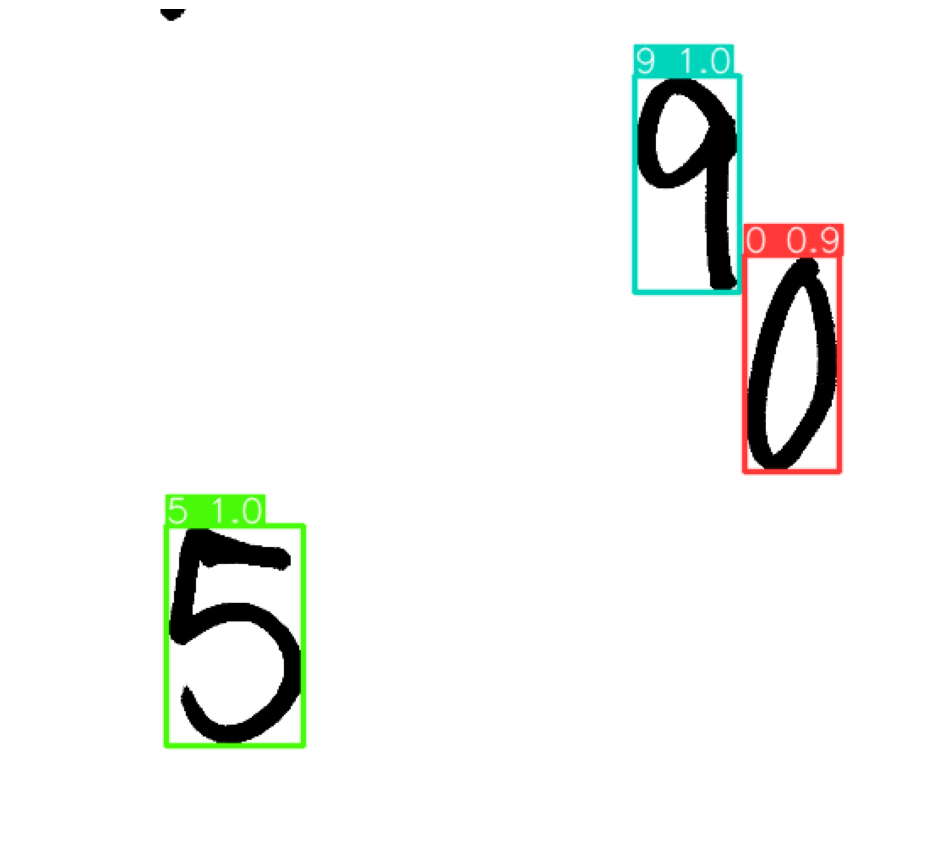

In [41]:
_ = onnx_model(img, 0.7, 0.25).visualize(plot=True)

---
# **yolo outputs to nms ONNX**

In [32]:
import onnx_graphsurgeon as gs
import numpy as np
import onnx

def create_onnx_NMS(filepath: str="nms.onnx", opset: int = 18):
    """Create ONNX NonMaxSupression which uses YOLO outputs to return boxes, scores and class_ids filtered out with NMS operation"""
    output0 = gs.Variable(name="output0", dtype=np.float32, shape=(1, "4 + num_classes", "num_boxes"))
    output0_transposed = gs.Variable(name="output0_transposed", dtype=np.float32, shape=(1, "num_boxes", "4 + num_classes"))
    node_transpose = gs.Node(op="Transpose", attrs={"perm": [0, 2, 1]}, inputs=[output0], outputs=[output0_transposed])

    shape = gs.Variable(name="shape", dtype=np.int64)
    node_shape = gs.Node(op="Shape", attrs={"start": -1}, inputs=[output0_transposed], outputs=[shape])

    boxes_starts = gs.Constant(name="boxes_starts", values=np.array([0], dtype=np.int64))
    boxes_ends = gs.Constant(name="boxes_ends", values=np.array([4], dtype=np.int64))
    boxes_axes = gs.Constant(name="boxes_axes", values=np.array([2], dtype=np.int64))
    boxes_xywh = gs.Variable(name="boxes_xywh", dtype=np.float32, shape=(1, "num_boxes", 4))
    node_slice_boxes = gs.Node(op="Slice", inputs=[output0_transposed, boxes_starts, boxes_ends, boxes_axes], outputs=[boxes_xywh])

    scores_starts = gs.Constant(name="scores_starts", values=np.array([4], dtype=np.int64))
    scores_ends = shape
    scores_axes = gs.Constant(name="scores_axes", values=np.array([2], dtype=np.int64))
    scores = gs.Variable(name="scores", dtype=np.float32, shape=(1, "num_boxes", None))
    node_slice_scores = gs.Node(op="Slice", inputs=[output0_transposed, scores_starts, scores_ends, scores_axes], outputs=[scores])

    class_scores = gs.Variable(name="class_scores", dtype=np.float32, shape=(1, "num_boxes", 1))
    axes = gs.Constant(name="axes", values=np.array([2], dtype=np.int64))
    node_max_scores = gs.Node(op="ReduceMax", attrs={"keepdims": 1}, inputs=[scores, axes], outputs=[class_scores])

    int64_class_ids = gs.Variable(name="int64_class_ids", dtype=np.int64, shape=(1, "num_boxes", 1))
    node_argmax_scores = gs.Node(op="ArgMax", attrs={"axis": 2, "keepdims": 1}, inputs=[scores], outputs=[int64_class_ids])

    class_ids = gs.Variable(name="class_ids", dtype=np.int32, shape=(1, "num_boxes", 1))
    node_cast_int64_to_int32 = gs.Node(op="Cast", attrs={"to": np.int32}, inputs=[int64_class_ids], outputs=[class_ids])


    class_scores_transposed = gs.Variable(name="class_scores_transposed", dtype=np.float32, shape=(1, 1, "num_boxes"))
    node_class_scores_transpose = gs.Node(op="Transpose", attrs={"perm": [0, 2, 1]}, inputs=[class_scores], outputs=[class_scores_transposed])


    int32_max_output_boxes_per_class = gs.Variable(name="int32_max_output_boxes_per_class", dtype=np.int32, shape=(1, ))
    int64_max_output_boxes_per_class = gs.Variable(name="int64_max_output_boxes_per_class", dtype=np.int64, shape=(1, ))
    node_cast_int32_to_int64 = gs.Node(op="Cast", attrs={"to": np.int64}, inputs=[int32_max_output_boxes_per_class], outputs=[int64_max_output_boxes_per_class])


    iou_threshold = gs.Variable(name="iou_threshold", dtype=np.float32, shape=(1, ))
    score_threshold = gs.Variable(name="score_threshold", dtype=np.float32, shape=(1, ))
    selected_indices = gs.Variable(name="selected_indices", dtype=np.int64, shape=("num_selected_boxes", 3))
    node_nms = gs.Node(
        op="NonMaxSuppression", 
        attrs={"center_point_box": 1}, 
        inputs=[boxes_xywh, class_scores_transposed, int64_max_output_boxes_per_class, iou_threshold, score_threshold], 
        outputs=[selected_indices]
    )

    indices = gs.Constant(name="indices", values=np.array(2, dtype=np.int64))
    selected_box_indices = gs.Variable(name="selected_box_indices", dtype=np.int64, shape=("num_selected_boxes", ))
    node_selected_indices = gs.Node(op="Gather", attrs={"axis": 1}, inputs=[selected_indices, indices], outputs=[selected_box_indices])

    # pick boxes using NMS indices
    squeezed_boxes_xywh = gs.Variable(name="squeezed_boxes_xywh", dtype=np.float32, shape=("num_boxes", 4))
    node_squeezed_boxes_xywh = gs.Node(op="Squeeze", inputs=[boxes_xywh], outputs=[squeezed_boxes_xywh])

    selected_boxes_xywh = gs.Variable(name="selected_boxes_xywh", dtype=np.float32, shape=("num_selected_boxes", 4))
    node_selected_boxes_xywh = gs.Node(op="Gather", attrs={"axis": 0}, inputs=[squeezed_boxes_xywh, selected_box_indices], outputs=[selected_boxes_xywh])

    # pick scores using NMS indices
    squeezed_class_scores = gs.Variable(name="squeezed_class_scores", dtype=np.float32, shape=("num_boxes",))
    node_squeezed_class_scores = gs.Node(op="Squeeze", inputs=[class_scores], outputs=[squeezed_class_scores])

    selected_class_scores = gs.Variable(name="selected_class_scores", dtype=np.float32, shape=("num_selected_boxes",))
    node_selected_class_scores = gs.Node(op="Gather", attrs={"axis": 0}, inputs=[squeezed_class_scores, selected_box_indices], outputs=[selected_class_scores])


    # pick class_ids using NMS indices
    squeezed_class_ids = gs.Variable(name="squeezed_class_ids", dtype=np.int32, shape=("num_boxes",))
    node_squeezed_class_ids = gs.Node(op="Squeeze", inputs=[class_ids], outputs=[squeezed_class_ids])

    selected_class_ids = gs.Variable(name="selected_class_ids", dtype=np.int32, shape=("num_selected_boxes",))
    node_selected_class_ids = gs.Node(op="Gather", attrs={"axis": 0}, inputs=[squeezed_class_ids, selected_box_indices], outputs=[selected_class_ids])

    graph = gs.Graph(
        nodes=[
            node_transpose, 
            node_shape, 
            node_slice_boxes, 
            node_slice_scores, 
            node_max_scores, 
            node_argmax_scores,
            node_cast_int64_to_int32,
            node_class_scores_transpose, 
            node_cast_int32_to_int64,
            node_nms, 
            node_selected_indices,
            node_squeezed_boxes_xywh,
            node_selected_boxes_xywh,
            node_squeezed_class_scores,
            node_selected_class_scores,
            node_squeezed_class_ids,
            node_selected_class_ids
        ], 
        inputs=[output0, int32_max_output_boxes_per_class, iou_threshold, score_threshold], 
        outputs=[selected_boxes_xywh, selected_class_scores, selected_class_ids], 
        opset=opset
    )
    onnx.save(gs.export_onnx(graph), filepath)

In [31]:
create_onnx_NMS(filepath="full_nms.onnx", opset=18)

In [192]:
outputs_transposed = outputs.transpose(0, 2, 1)          # V

boxes_xywh = outputs_transposed[..., :4]      # V
class_scores = outputs_transposed[..., 4:]    # V

scores = class_scores.max(axis=2, keepdims=True) # V
scores = scores.transpose(0, 2, 1)  # V

class_ids = class_scores.argmax(axis=2).squeeze()

iou_threshold = np.array([0.7], dtype=np.float32)
score_threshold = np.array([0.25], dtype=np.float32)

pad_x, pad_y = pad
w = onnx_model.input_w - pad_x * 2
h = onnx_model.input_h - pad_y * 2

boxes_xywh[:, :, 0] -= pad_x
boxes_xywh[:, :, 1] -= pad_y

boxes_xywhn = np.divide(boxes_xywh, np.array([w, h, w, h]))

In [27]:
pre_nms = ort.InferenceSession("full_nms.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])

In [28]:
pre_nms_data = pre_nms.run(
    ["selected_boxes_xywh", "selected_class_scores", "selected_class_ids"], 
    {
        "output0": outputs, 
        "int32_max_output_boxes_per_class": np.array([100], dtype=np.int32),
        'iou_threshold': np.array([0.7], dtype=np.float32), 
        'score_threshold': np.array([0.25], dtype=np.float32)
    }
)
pre_nms_data

---
# **preprocessing onnx**

In [337]:
image = Image.open("../datasets/yolo_HWD+/images/test/42.png")
image = Image.open("../datasets/SVHN/examples/5.png")

image_ = np.asarray(image)
image_ = image_[100:-50, 40:-50]
img = np.copy(image_)

input_h, input_w, input_c = 256, 256, 3
fill_value = 114

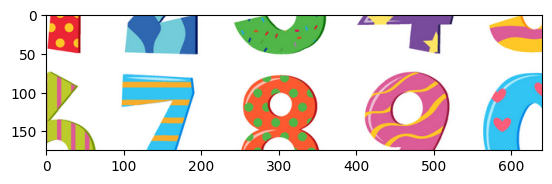

In [338]:
plt.imshow(image_)

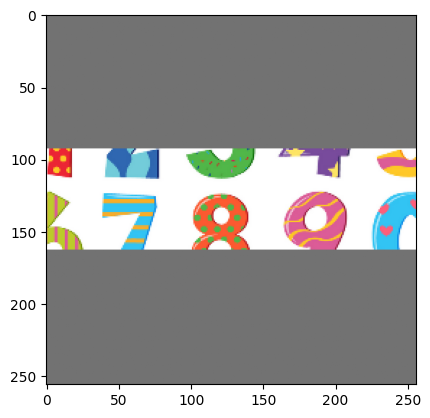

In [339]:
plt.imshow(onnx_model.prepare_input(image_)[0][0].transpose(1, 2, 0))

In [220]:
onnx_model.prepare_input(image_)[0].shape

(1, 3, 256, 256)

In [343]:
def _const(name, value, dtype):
    return gs.Constant(name=name, values=np.array([value], dtype=dtype))

def parse_outs(outs, dtypes, names):
    for i in range(len(outs)):
        outs[i].dtype = dtypes[i]
        outs[i].name = names[i]
    return outs

@gs.Graph.register()
def slice_tensor(self, input_image, starts: int = 0, ends: int = 3, axes: int = 2, outputs=["slice"]):
    outs = self.layer(
        op="Slice", 
        inputs=[
            input_image, 
            _const("starts", starts, np.int64), 
            _const("ends", ends, np.int64), 
            _const("axes", axes, np.int64)
        ], 
        outputs=outputs
    )
    return parse_outs(outs, [input_image.dtype], outputs)
    
@gs.Graph.register()
def shape(self, rgb_image, outputs=["shape"]):
    outs = self.layer(
        op="Shape",
        inputs=[rgb_image],
        outputs=outputs
    )
    return parse_outs(outs, [np.int64], outputs)

@gs.Graph.register()
def div(self, a, b, outputs=["ratio"]):
    outs = self.layer(
        op="Div",
        inputs=[a, b],
        outputs=outputs
    )
    return parse_outs(outs, [a.dtype], outputs)

@gs.Graph.register()
def sub(self, a, b, outputs=["diff"]):
    outs = self.layer(
        op="Sub",
        inputs=[a, b],
        outputs=outputs
    )
    return parse_outs(outs, [a.dtype], outputs)

@gs.Graph.register()
def get_item(self, tensor, axis, idx, outputs=["item"]):
    outs = self.layer(
        op="Gather",
        attrs={"axis": axis},
        inputs=[tensor, _const(f"index_{idx}", idx, np.int64)],
        outputs=outputs
    )
    return parse_outs(outs, [tensor.dtype], outputs)

@gs.Graph.register()
def cast(self, a, dtype, outputs=["casted"]):
    outs = self.layer(
        op="Cast",
        attrs={"to": dtype},
        inputs=[a],
        outputs=outputs
    )
    return parse_outs(outs, [dtype], outputs)

@gs.Graph.register()
def is_greater(self, a, b, outputs=["is_greater"]):
    outs = self.layer(
        op="Greater",
        inputs=[a, b],
        outputs=outputs
    )
    return parse_outs(outs, [np.bool_], outputs)

@gs.Graph.register()
def if_statement(self, cond, then_branch, else_branch, dtypes=[np.float32], outputs=["if_out"]):
    outs = self.layer(
        op="If",
        attrs={"then_branch": then_branch, "else_branch": else_branch},
        inputs=[cond],
        outputs=outputs
    )
    return parse_outs(outs, dtypes, outputs)
    
@gs.Graph.register()
def identity(self, a, outputs=["copy"]):
    outs = self.layer(
        op="Identity",
        inputs=[a],
        outputs=outputs
    )
    return parse_outs(outs, [a.dtype], outputs)

@gs.Graph.register()
def constant(self, a, outputs=["const"]):
    outs = self.layer(
        op="Constant",
        attrs={"value": a},
        outputs=outputs
    )
    return parse_outs(outs, [a.dtype], outputs)

@gs.Graph.register()
def concat(self, inputs, axis: int = 0, outputs=["concat_results"]):
    outs = self.layer(
        op="Concat",
        attrs={"axis": axis},
        inputs=inputs,
        outputs=outputs
    )
    return parse_outs(outs, [inputs[0].dtype], outputs)

@gs.Graph.register()
def resize(self, image, sizes, outputs=["resized"]):
    outs = self.layer(
        op="Resize",
        attrs={"mode": "linear", "axes": [0, 1]},
        inputs=[
            image, 
            _const("", "", np.str_), # roi
            _const("", "", np.str_), # scales
            sizes
        ],
        outputs=outputs
    )
    return parse_outs(outs, [image.dtype], outputs)

@gs.Graph.register()
def pad_image(self, image, pads, constant_value: int = 114, outputs=["padded"]):
    # pads = [pad_top, pad_left, pad_bottom, pad_right]
    outs = self.layer(
        op="Pad",
        attrs={"mode": "constant"},
        inputs=[
            image, # data
            pads, # pads
            _const("constant_value", constant_value, np.uint8), # constant_value
            gs.Constant("pad_axes", np.array([0, 1], dtype=np.int64)), # axes
        ],
        outputs=outputs
    )
    return parse_outs(outs, [image.dtype], outputs)


@gs.Graph.register()
def transpose(self, tensor, perm=[2, 0, 1], outputs=["transposed"]):
    outs = self.layer(
        op="Transpose",
        attrs={"perm": perm},
        inputs=[tensor],
        outputs=outputs
    )
    return parse_outs(outs, [tensor.dtype], outputs)

graph = gs.Graph(opset=18)

input_h_int32 = gs.Variable(name="input_h_int32", dtype=np.int32, shape=(1, ))
input_h = graph.cast(input_h_int32, dtype=np.int64, outputs=["input_h"])
input_h_float = graph.cast(*input_h, dtype=np.float32, outputs=["input_h_float"])

input_w_int32 = gs.Variable(name="input_w_int32", dtype=np.int32, shape=(1, ))
input_w = graph.cast(input_w_int32, dtype=np.int64, outputs=["input_w"])
input_w_float = graph.cast(*input_w, dtype=np.float32, outputs=["input_w_float"])


input_image = gs.Variable(name="input_image", dtype=np.uint8, shape=("height", "width", "channels"))
inputs = [input_image, input_h_int32, input_w_int32]
graph.inputs = inputs


rgb_image = graph.slice_tensor(input_image, outputs=['X'])
img_shape = graph.shape(*rgb_image) # HWC

img_h_int = graph.get_item(*img_shape, axis=0, idx=0, outputs=['img_h_int'])
img_h = graph.cast(*img_h_int, dtype=np.float32, outputs=["img_h"])

img_w_int = graph.get_item(*img_shape, axis=0, idx=1, outputs=['img_w_int'])
img_w = graph.cast(*img_w_int, dtype=np.float32, outputs=["img_w"])

img_c_int = graph.get_item(*img_shape, axis=0, idx=2, outputs=['img_c_int'])


aspect_ratio = graph.div(*img_w, *img_h, outputs=['aspect_ratio'])

is_greater = graph.is_greater(*aspect_ratio, _const("one", 1, np.float32), outputs=['is_greater'])

then_subgraph = gs.Graph(opset=18)
then_img_h = then_subgraph.div(*input_w_float, *aspect_ratio, outputs=['then_img_h'])
then_img_w = then_subgraph.identity(*input_w_float, outputs=['then_img_w'])
then_subgraph.outputs = then_img_h + then_img_w

else_subgraph = gs.Graph(opset=18)
else_img_h = else_subgraph.identity(*input_h_float, outputs=['else_img_h'])
else_img_w = else_subgraph.div(*input_h_float, *aspect_ratio, outputs=['else_img_w'])
else_subgraph.outputs = else_img_h + else_img_w

new_img_h_float, new_img_w_float = graph.if_statement(*is_greater, then_subgraph, else_subgraph, dtypes=[np.float32, np.float32], outputs=["new_img_h_float", "new_img_w_float"])
new_img_h = graph.cast(new_img_h_float, dtype=np.int64, outputs=["new_img_h"])
new_img_w = graph.cast(new_img_w_float, dtype=np.int64, outputs=["new_img_w"])


hw_size_float = graph.concat([new_img_h_float, new_img_w_float], axis=0, outputs=["hw_size_float"])
sizes = graph.cast(*hw_size_float, dtype=np.int64, outputs=["sizes"])

resized_img = graph.resize(*rgb_image, *sizes, outputs=["resized_img"])

scalar_2 = _const(f"scalar_2", 2, dtype=np.int64)
pad_x = graph.sub(*input_w, *new_img_w, outputs=["pad_x"])
pad_left_float = graph.div(*pad_x, scalar_2, outputs=["pad_left_float"])
pad_left = graph.cast(*pad_left_float, np.int64, outputs=["pad_left"])
pad_right = graph.sub(*pad_x, *pad_left, outputs=["pad_right"])

pad_y = graph.sub(*input_h, *new_img_h, outputs=["pad_y"])
pad_top_float = graph.div(*pad_y, scalar_2, outputs=["pad_top_float"])
pad_top = graph.cast(*pad_top_float, np.int64, outputs=["pad_top"])
pad_bottom = graph.sub(*pad_y, *pad_top, outputs=["pad_bottom"])

padding = pad_top + pad_left + pad_bottom + pad_right
pads = graph.concat(padding, axis=0, outputs=["pads"])
padded_img = graph.pad_image(*resized_img, *pads, constant_value=114, outputs=['padded_img'])

float_img = graph.cast(*padded_img, np.float32, outputs=["float_img"])
scalar_255 = _const("scalar_255", 255, dtype=np.float32)
normalized_img = graph.div(*float_img, scalar_255, outputs=["normalized_img"])

transposed_img = graph.transpose(*normalized_img, perm=[2, 0, 1], outputs=["preprocessed_img"])

graph.outputs = transposed_img
onnx.save(gs.export_onnx(graph), "preprocessing.onnx")

In [332]:
img = img[..., :input_c]    # V

img_h, img_w, img_c = img.shape   # V
aspect_ratio = img_w / img_h  # V
if aspect_ratio > 1:  # V
    new_img_h = int(input_w / aspect_ratio)  # V
    new_img_w = input_w  # V
else:  # V
    new_img_h = input_h  # V
    new_img_w = int(input_h / aspect_ratio)  # V
    
resized_img = cv2.resize(img, (new_img_w, new_img_h), interpolation=cv2.INTER_LINEAR)  # V

# width, height ratios
padded_img = np.ones((input_h, input_w, img_c)) * fill_value
left = (input_w - new_img_w) // 2
bottom = (input_h - new_img_h) // 2

padded_img[bottom : bottom + new_img_h, left : left + new_img_w] = resized_img
pad_x = (input_w - new_img_w) // 2
pad_y = (input_h - new_img_h) // 2

pad = (pad_x, pad_y)
img = padded_img

img = img / 255.0
img = img.transpose(2, 0, 1)
input_tensor = img.astype(np.float32)
# input_tensor = np.expand_dims(img, 0).astype(np.float32)

In [350]:
image = Image.open("../datasets/yolo_HWD+/images/test/42.png")
image_ = np.asarray(image)

preprocessing = ort.InferenceSession("preprocessing.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])

In [355]:
inputs = {
    "input_image": image_, 
    "input_h_int32": np.array([256], dtype=np.int32), 
    "input_w_int32": np.array([256], dtype=np.int32)
}
%timeit preprocessed = preprocessing.run(None, inputs)

2.57 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


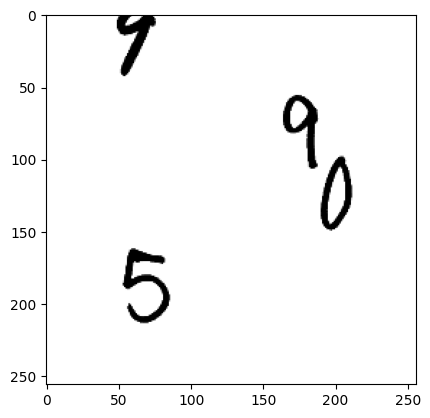

In [348]:
plt.imshow(preprocessed[0].transpose(1, 2, 0))

In [357]:
%timeit onnx_model.prepare_input(image_)

406 µs ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


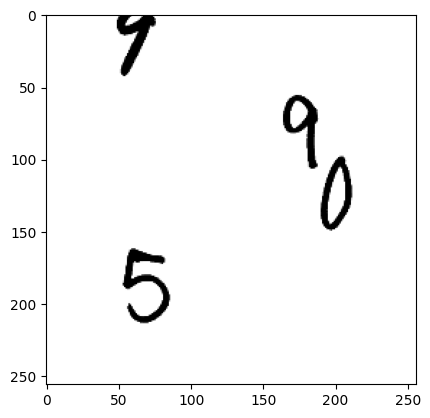

In [349]:
plt.imshow(onnx_model.prepare_input(image_)[0][0].transpose(1, 2, 0))

In [341]:
preprocessed[7].shape

(256, 256, 3)

In [342]:
image_.shape

(175, 640, 4)

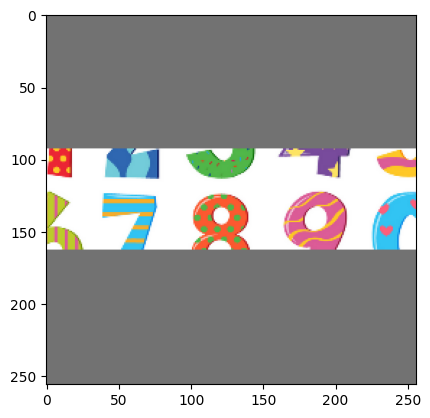

In [318]:
plt.imshow(preprocessed[7])

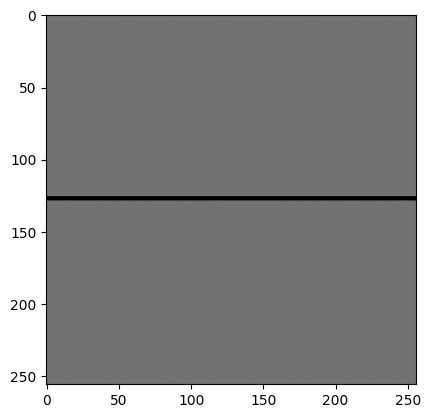

In [334]:
plt.imshow(padded_img/255)

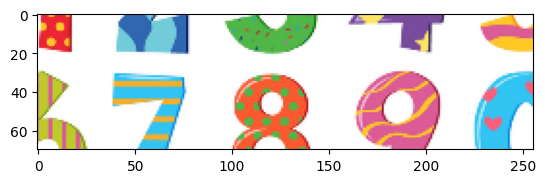

In [328]:
plt.imshow(resized_img)

In [331]:
np.all(padded_img == 114)

False

In [263]:
resized_img.shape

(70, 256, 3)

In [268]:
padded.shape

(110, 296, 43)

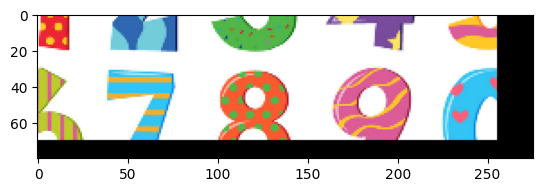

In [272]:
padded = np.pad(resized_img, [[0, 10], [0, 20], [0, 0]])
plt.imshow(padded)

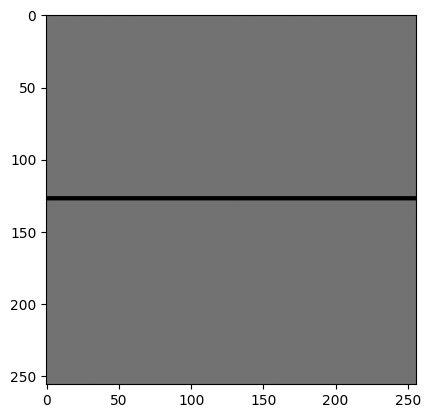

In [333]:
plt.imshow(input_tensor.transpose(1, 2, 0))

In [76]:
import cv2

In [ ]:
cv2.interpo